# Visualize and store covariate ranges

In [8]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [9]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # ignore Future deprecation warning
import os
import pickle
from scipy.stats import levene
from scipy.stats import ttest_ind
from scipy.stats import kruskal
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from classes import boundaries as bd
from classes import functions as fcy
from classes import snag_MTF_func as sg

plot_setup = bd.plot_setup()
params = {'mathtext.default':'regular'}
plt.rcParams.update(params)

%matplotlib inline
%config Completer.use_jedi = False 




#--- Notebook run settings
climate_data_list  = ['CRUclim','CRUNCEPv7','CHELSA30s','WorldClim30s','WorldClim10m',]
climate_data       = climate_data_list[1]
remove_data        = True

In [10]:
#---------------#
#  Import data  #
#---------------#

cols = ['MAT','Humidity','DBH mean','Dominant_mortality cause','MTF basis','Continent','Fire','MTF','Managed',
        'Mortality','PFT','Country','Region','Site name','Reference']

#--- Site MTF
site_mtf = sg.MTF_database_import('data/MTF_database.xlsx','Site_MTF')
site_mtf.loc[site_mtf['Site name'].isna(),'Site name'] = ''
site_mtf.loc[site_mtf['Y coords'].isna(),'Y coords'] = ''
site_mtf.loc[site_mtf['X coords'].isna(),'X coords'] = ''
site_mtf['MAT'] = site_mtf[(climate_data,'MAT')]
site_mtf_cp = site_mtf.copy()
site_mtf = site_mtf.loc[site_mtf['MTF basis'] == 'count', cols]
site_mtf.columns = site_mtf.columns.get_level_values(0)

#--- Species
species_mtf = sg.MTF_database_import('data/MTF_database.xlsx','Species_MTF')
species_mtf.loc[species_mtf['Site name'].isna(),'Site name'] = ''
species_mtf.loc[species_mtf['Y coords'].isna(),'Y coords'] = ''
species_mtf.loc[species_mtf['X coords'].isna(),'X coords'] = ''
species_mtf['MAT'] = species_mtf[(climate_data,'MAT')]
species_mtf_cp = species_mtf.copy()
species_mtf = species_mtf.loc[species_mtf['MTF basis'] == 'count', cols+['Species']]
species_mtf.columns = species_mtf.columns.get_level_values(0)

In [11]:
site_mtf.columns

Index(['MAT', 'Humidity', 'DBH mean', 'Dominant_mortality cause', 'MTF basis',
       'Continent', 'Fire', 'MTF', 'Managed', 'Mortality', 'PFT', 'Country',
       'Region', 'Site name', 'Reference'],
      dtype='object')

In [12]:
#---------------#
#  Import data  #
#---------------#

data = [site_mtf, species_mtf]
    
#--------------------#
#   Transform data   #
#--------------------#

for i,mtf in enumerate(data):
    print(len(mtf))
    if remove_data:    
        mtf = mtf[~(mtf.Reference == 'Ritchie2014EstablishmentForest')].copy()
        mtf = mtf[~(mtf.Reference == 'Campbell2016CarbonStates')].copy()

    mtf.loc[:, 'MTF']           = mtf.loc[:, 'MTF'].apply(np.log) # necessary to fullfill normality of the residuals requirement of multiple regression and ANCOVA
    
    data[i] = mtf
    print(len(mtf))

87
85
151
146



 MAT & DBH subset
N Fire mort: 20
N Insect mort: 11
N Other mort: 39

 MAT & DBH subset
N Fire mort: 43
N Insect mort: 10
N Other mort: 63


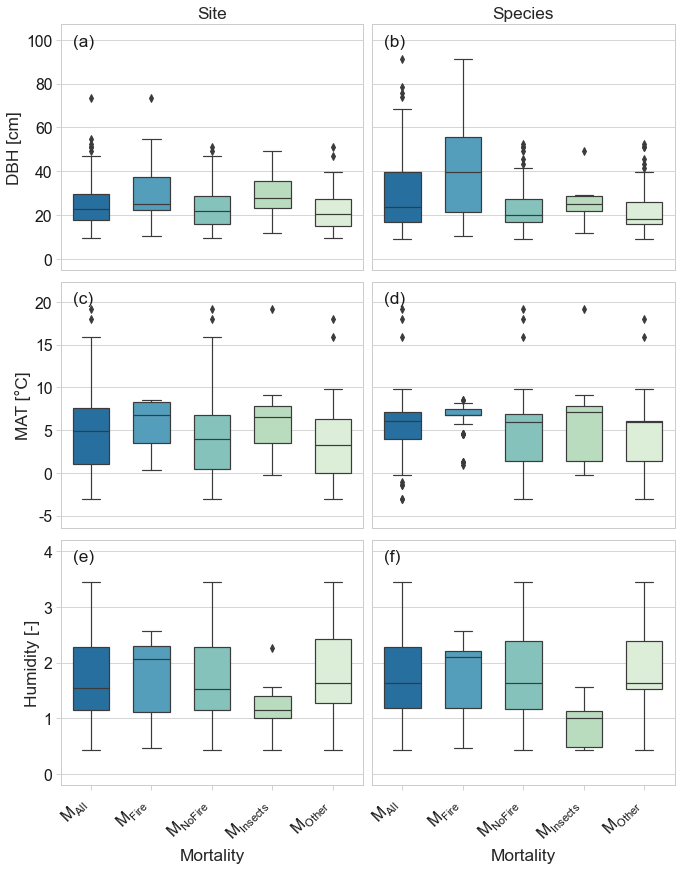

In [13]:
var_list   = ['DBH mean', 'MAT', 'Humidity']
mort_order = ['All','Fire','No Fire', 'Insects', 'Other']
mort_order_store = ['M_All','M_Fire','M_NoFire', 'M_Insects', 'M_Other']
mort_plot  = ['$M_{All}$','$M_{Fire}$','$M_{No Fire}$', '$M_{Insects}$', '$M_{Other}$']
fac = 0.8


data_mort = np.empty((2,),dtype='object')

# Plot settings
sns.set_context("paper", font_scale=1.8)
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left']   = True
plt.rcParams['xtick.color']  = 'lightgrey'
plt.rcParams['ytick.color']  = 'lightgrey'
fig, ax = plt.subplots(len(var_list),2, figsize=(11,14),sharex=True)


for i,mtf in enumerate(data):

    if i == 0:
        mtf = mtf.dropna(subset=['MAT','DBH mean']).copy()
    else:
        mtf = mtf.dropna(subset=['MAT','DBH mean','Humidity', 'PFT']).copy()
    print('\n MAT & DBH subset')    
    print('N Fire mort: {}'.format(len(mtf[(mtf['MTF basis'] == 'count') & (mtf['Mortality'] == 'Fire')])))
    print('N Insect mort: {}'.format(len(mtf[(mtf['MTF basis'] == 'count') & (mtf['Mortality'] == 'Insects')])))
    print('N Other mort: {}'.format(len(mtf[(mtf['MTF basis'] == 'count') & (mtf['Mortality'] == 'Other')])))
    
    #--- Boxplotting mortality group - 
    #    appending the entire DF (axis=0) setting Mortality to 'ALL' to compare data of Mortality selections

    mtf_all_mort_copy = mtf.copy()
    mtf_all_mort_copy['Mortality'] = 'All'
    
    if i == 0: # At site level for all mortality, management is a covariate, so subsetting data
        mtf_all_mort_copy = mtf_all_mort_copy[mtf_all_mort_copy.Managed.notna()]
    
    mtf_no_fire_mort  = mtf.copy()
    mtf_no_fire_mort.loc[(mtf_no_fire_mort.Fire == 0), 'Mortality'] = 'No Fire'
    mtf_no_fire_mort  = mtf_no_fire_mort[mtf_no_fire_mort.Mortality == 'No Fire']
    
    
    
    mtf_mort_extended = pd.concat([mtf,
                                   mtf_all_mort_copy,
                                   mtf_no_fire_mort],axis=0)
    
    data_mort[i] = mtf_mort_extended
    
    for v,var in enumerate(var_list):
        g = sns.boxplot(data=mtf_mort_extended, 
                    #hue='MTF basis', 
                    x='Mortality',
                    y=var, 
                    width=0.6, 
                    palette=sns.color_palette("GnBu_r",5),
                    order=mort_order,
                    ax=ax[v,i])
        
        ax[v,i].legend([],[], frameon=False)
        ax[v,i].set_xlabel(None)
        if i == 1:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                ax[v,i].set_ylabel(None) 
                ax[v,i].yaxis.set_ticks_position('none') 
                ax[v,i].set_yticklabels(ax[v,i].get_yticklabels(),color='#FF000000' )
        if v < (len(var_list)-1):
            ax[v,i].xaxis.set_ticks_position('none') 
        
ax[0,0].set_title('Site')
ax[0,1].set_title('Species') 
ax[2,0].set_xlabel('Mortality') 
ax[2,1].set_xlabel('Mortality') 
ax[0,0].set_ylabel('DBH [cm]') 
ax[1,0].set_ylabel('MAT [°C]') 
ax[2,0].set_ylabel('Humidity [-]') 
ax[len(var_list)-1,0].set_xticklabels(mort_order, rotation = 45, ha="right")
ax[len(var_list)-1,1].set_xticklabels(mort_order, rotation = 45, ha="right")

y_max = [102,21,4]
y_min = [0,-5.1,0]
# Adjust yrange
for j in range(3):
    for i in range(2):
        pts = ax[j,i].dataLim.get_points()  # numpy array [[xmin, ymin], [xmax, ymax]]
        pts[1, 1] = y_max[j]  # new ymax
        pts[0, 1] = y_min[j]  # new ymin
        ax[j,i].dataLim.set_points(pts)
        ax[j,i].autoscale_view()
    
ax[0,0].annotate(xy=(-0.3,97),text='(a)',color='k')
ax[0,1].annotate(xy=(-0.3,97),text='(b)',color='k')

ax[1,0].annotate(xy=(-0.3,19.8),text='(c)',color='k')
ax[1,1].annotate(xy=(-0.3,19.8),text='(d)',color='k')

ax[2,0].annotate(xy=(-0.3,3.82),text='(e)',color='k')
ax[2,1].annotate(xy=(-0.3,3.82),text='(f)',color='k')


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ax[0,0].set_yticklabels(np.arange(-20,120,20),color='k')
    ax[1,0].set_yticklabels(np.arange(-10,25,5),color='k')
    ax[2,0].set_yticklabels(np.arange(-1,5),color='k')
    ax[2,0].set_xticklabels(mort_plot, color='k')
    ax[2,1].set_xticklabels(mort_plot, color='k')
plt.subplots_adjust(wspace=0.03,hspace=0.05)
plt.savefig('Appendix_FigureB3_regression_covariates_mortality_group.png', dpi=300, bbox_inches='tight')
plt.show()

## Mean and range of covariates

In [14]:
cov_vars = ['DBH mean','MAT','Humidity','PFT']
level_option_list = ['Site','Species']

df_clim_stats       = pd.DataFrame() # Paper
df_clim_stats_store = pd.DataFrame() # Storage

for m,mtf_mort_extended in enumerate(data_mort):
    clim_stats_mean = mtf_mort_extended[(mtf_mort_extended['MTF basis'] == 'count')].groupby('Mortality').mean()[
                            cov_vars].round(2)
    clim_stats_min  = mtf_mort_extended[(mtf_mort_extended['MTF basis'] == 'count')].groupby('Mortality').min()[
                            cov_vars].round(1)
    clim_stats_max  = mtf_mort_extended[(mtf_mort_extended['MTF basis'] == 'count')].groupby('Mortality').max()[
                            cov_vars].round(1)
    clim_stats_n    = mtf_mort_extended[(mtf_mort_extended['MTF basis'] == 'count')].groupby('Mortality').count()['MTF']
    index_data = clim_stats_n.index.to_list()
    clim_stats_n = clim_stats_n.to_frame().T[mort_order].T
    print(clim_stats_n.index)
    clim_stats = pd.DataFrame()
    
    # Table for paper
    for i,j in enumerate(cov_vars):
        mean = clim_stats_mean[j].to_list()
        max_ = clim_stats_max[j].to_list()
        min_ = clim_stats_min[j].to_list()
        if j == 'PFT':
            clim_stats[j] = mean
        else:
            clim_stats[j] = [str(a)+' ('+str(m)+'—'+str(o)+')' for a,o,m in zip(mean,max_,min_)]
    
    clim_stats.index = index_data
    display(clim_stats)
    clim_stats = clim_stats.T[mort_order].T
    clim_stats['Nobs'] = clim_stats_n
    display(clim_stats)
    clim_stats.index = mort_order_store

    idx_mult = pd.MultiIndex.from_tuples((level_option_list[m],j) for j in clim_stats.index.to_list())
    clim_stats.index = idx_mult
    
    df_clim_stats = pd.concat([df_clim_stats,clim_stats])
    
    
    # Table for testing models for difference (min - max)
    idx_mult_min  = pd.MultiIndex.from_tuples((level_option_list[m],'Min',j) for j in clim_stats_min.index.to_list())
    idx_mult_max  = pd.MultiIndex.from_tuples((level_option_list[m],'Max',j) for j in clim_stats_min.index.to_list())
    idx_mult_mean = pd.MultiIndex.from_tuples((level_option_list[m],'Mean',j) for j in clim_stats_min.index.to_list())
    
    clim_stats_min.index  = idx_mult_min
    clim_stats_max.index  = idx_mult_max
    clim_stats_mean.index = idx_mult_mean
    
    df_clim_stats_store = pd.concat([df_clim_stats_store, clim_stats_min,clim_stats_max,clim_stats_mean])
    
display(df_clim_stats)
#print(df_clim_stats.to_latex())   

display(df_clim_stats_store)
#df_clim_stats_store.to_pickle('covariate_mean_range_data.pkl')

Index(['All', 'Fire', 'No Fire', 'Insects', 'Other'], dtype='object', name='Mortality')


,DBH mean,MAT,Humidity,PFT
All,26.04 (9.4—73.6),4.72 (-3.1—19.2),1.68 (0.4—3.4),0.93
Fire,31.13 (10.4—73.6),5.74 (0.3—8.5),1.68 (0.5—2.6),1.00
Insects,28.59 (11.7—49.0),6.45 (-0.3—19.2),1.19 (0.4—2.3),0.91
No Fire,24.0 (9.4—50.9),4.32 (-3.1—19.2),1.68 (0.4—3.4),0.90
Other,22.71 (9.4—50.9),3.71 (-3.1—18.0),1.81 (0.4—3.4),0.90


,DBH mean,MAT,Humidity,PFT,Nobs
All,26.04 (9.4—73.6),4.72 (-3.1—19.2),1.68 (0.4—3.4),0.93,70
Fire,31.13 (10.4—73.6),5.74 (0.3—8.5),1.68 (0.5—2.6),1.0,20
No Fire,24.0 (9.4—50.9),4.32 (-3.1—19.2),1.68 (0.4—3.4),0.9,50
Insects,28.59 (11.7—49.0),6.45 (-0.3—19.2),1.19 (0.4—2.3),0.91,11
Other,22.71 (9.4—50.9),3.71 (-3.1—18.0),1.81 (0.4—3.4),0.9,39


Index(['All', 'Fire', 'No Fire', 'Insects', 'Other'], dtype='object', name='Mortality')


,DBH mean,MAT,Humidity,PFT
All,29.49 (8.9—91.1),5.43 (-3.1—19.2),1.74 (0.4—3.4),0.78
Fire,39.95 (10.4—91.1),6.33 (0.9—8.5),1.74 (0.5—2.6),0.98
Insects,26.04 (11.7—49.0),6.35 (-0.3—19.2),0.88 (0.4—1.6),0.90
No Fire,23.34 (8.9—52.4),4.9 (-3.1—19.2),1.74 (0.4—3.4),0.66
Other,22.91 (8.9—52.4),4.67 (-3.1—18.0),1.87 (0.4—3.4),0.62


,DBH mean,MAT,Humidity,PFT,Nobs
All,29.49 (8.9—91.1),5.43 (-3.1—19.2),1.74 (0.4—3.4),0.78,116
Fire,39.95 (10.4—91.1),6.33 (0.9—8.5),1.74 (0.5—2.6),0.98,43
No Fire,23.34 (8.9—52.4),4.9 (-3.1—19.2),1.74 (0.4—3.4),0.66,73
Insects,26.04 (11.7—49.0),6.35 (-0.3—19.2),0.88 (0.4—1.6),0.9,10
Other,22.91 (8.9—52.4),4.67 (-3.1—18.0),1.87 (0.4—3.4),0.62,63


DBH mean               MAT        Humidity   PFT  \
Site    M_All       26.04 (9.4—73.6)  4.72 (-3.1—19.2)  1.68 (0.4—3.4)  0.93   
        M_Fire     31.13 (10.4—73.6)    5.74 (0.3—8.5)  1.68 (0.5—2.6)   1.0   
        M_NoFire     24.0 (9.4—50.9)  4.32 (-3.1—19.2)  1.68 (0.4—3.4)   0.9   
        M_Insects  28.59 (11.7—49.0)  6.45 (-0.3—19.2)  1.19 (0.4—2.3)  0.91   
        M_Other     22.71 (9.4—50.9)  3.71 (-3.1—18.0)  1.81 (0.4—3.4)   0.9   
Species M_All       29.49 (8.9—91.1)  5.43 (-3.1—19.2)  1.74 (0.4—3.4)  0.78   
        M_Fire     39.95 (10.4—91.1)    6.33 (0.9—8.5)  1.74 (0.5—2.6)  0.98   
        M_NoFire    23.34 (8.9—52.4)   4.9 (-3.1—19.2)  1.74 (0.4—3.4)  0.66   
        M_Insects  26.04 (11.7—49.0)  6.35 (-0.3—19.2)  0.88 (0.4—1.6)   0.9   
        M_Other     22.91 (8.9—52.4)  4.67 (-3.1—18.0)  1.87 (0.4—3.4)  0.62   

                   Nobs  
Site    M_All        70  
        M_Fire       20  
        M_NoFire     50  
        M_Insects    11  
        M_Other      39  
Species M_All       116  
        M_Fire       43  
        M_NoFire     73  
        M_Insects    10  
        M_Other      63

DBH mean    MAT  Humidity   PFT
Site    Min  All          9.40  -3.10      0.40  0.00
             Fire        10.40   0.30      0.50  1.00
             Insects     11.70  -0.30      0.40  0.00
             No Fire      9.40  -3.10      0.40  0.00
             Other        9.40  -3.10      0.40  0.00
        Max  All         73.60  19.20      3.40  1.00
             Fire        73.60   8.50      2.60  1.00
             Insects     49.00  19.20      2.30  1.00
             No Fire     50.90  19.20      3.40  1.00
             Other       50.90  18.00      3.40  1.00
        Mean All         26.04   4.72      1.68  0.93
             Fire        31.13   5.74      1.68  1.00
             Insects     28.59   6.45      1.19  0.91
             No Fire     24.00   4.32      1.68  0.90
             Other       22.71   3.71      1.81  0.90
Species Min  All          8.90  -3.10      0.40  0.00
             Fire        10.40   0.90      0.50  0.00
             Insects     11.70  -0.30      0.40  0.00
             No Fire      8.90  -3.10      0.40  0.00
             Other        8.90  -3.10      0.40  0.00
        Max  All         91.10  19.20      3.40  1.00
             Fire        91.10   8.50      2.60  1.00
             Insects     49.00  19.20      1.60  1.00
             No Fire     52.40  19.20      3.40  1.00
             Other       52.40  18.00      3.40  1.00
        Mean All         29.49   5.43      1.74  0.78
             Fire        39.95   6.33      1.74  0.98
             Insects     26.04   6.35      0.88  0.90
             No Fire     23.34   4.90      1.74  0.66
             Other       22.91   4.67      1.87  0.62